# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'
p_type = 'FMB'
cluster = 1

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [ ]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [ ]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [ ]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 35)


In [ ]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  
dataset = dataset[dataset['Cluster']==1].reset_index(drop=True).copy()

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (75685, 36)


In [ ]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    75418
Ct 90_결과      39954
M/B_결과            0
M/B_기준            0
Scorch_결과     13169
Vm_결과         29498
경도_결과         56760
dtype: int64


## ***MODELLING***
---

In [ ]:
### Train Test Split 
# Targets 
targets = ['Ct 90_결과','Scorch_결과','Vm_결과','경도_결과']

# CT90 
ct_train_dataset, ct_test_dataset, ct_scaler, ct_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type)

# Scorch
sc_train_dataset, sc_test_dataset, sc_scaler, sc_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type)

# Vm 
vm_train_dataset, vm_test_dataset, vm_scaler, vm_scaler_cols = create_train_test_dataset(dataset, targets[2], p_type)

# Hard 
hard_train_dataset, hard_test_dataset, hard_scaler, hard_scaler_cols = create_train_test_dataset(dataset, targets[3], p_type)

# Print 
print('='*100)
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100) 

Ct 90_결과             |          6,110 |         1,434
Scorch_결과            |          8,537 |         2,003
Vm_결과                |         18,863 |         4,425
경도_결과               |         13,855 |         3,251


[I 2025-10-30 15:39:21,412] A new study created in memory with name: no-name-916054ea-623c-472a-a378-562c04cf989a


학습할 Tree Features: 18 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Cluster']
학습 Tree 데이터 수: 6110


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-30 15:39:25,232] Trial 0 finished with value: 7.1684695634139315 and parameters: {'n_estimators': 2052, 'max_depth': 8, 'learning_rate': 0.0035893530419273813, 'subsample': 0.829802312353722, 'gamma': 0.40397195404493375, 'reg_lambda': 0.6342458106308934}. Best is trial 0 with value: 7.1684695634139315.
[I 2025-10-30 15:39:26,853] Trial 1 finished with value: 7.29886207345142 and parameters: {'n_estimators': 2280, 'max_depth': 8, 'learning_rate': 0.12860607749829014, 'subsample': 0.7417313125316735, 'gamma': 0.1455178470525077, 'reg_lambda': 0.017514254481651437}. Best is trial 0 with value: 7.1684695634139315.
[I 2025-10-30 15:39:27,431] Trial 2 finished with value: 7.129814030166774 and parameters: {'n_estimators': 303, 'max_depth': 8, 'learning_rate': 0.1059858781371604, 'subsample': 0.9650813953233511, 'gamma': 0.34776434847617704, 'reg_lambda': 0.07679124281654706}. Best is trial 2 with value: 7.129814030166774.
[I 2025-10-30 15:39:27,819] Trial 3 finished with value: 2

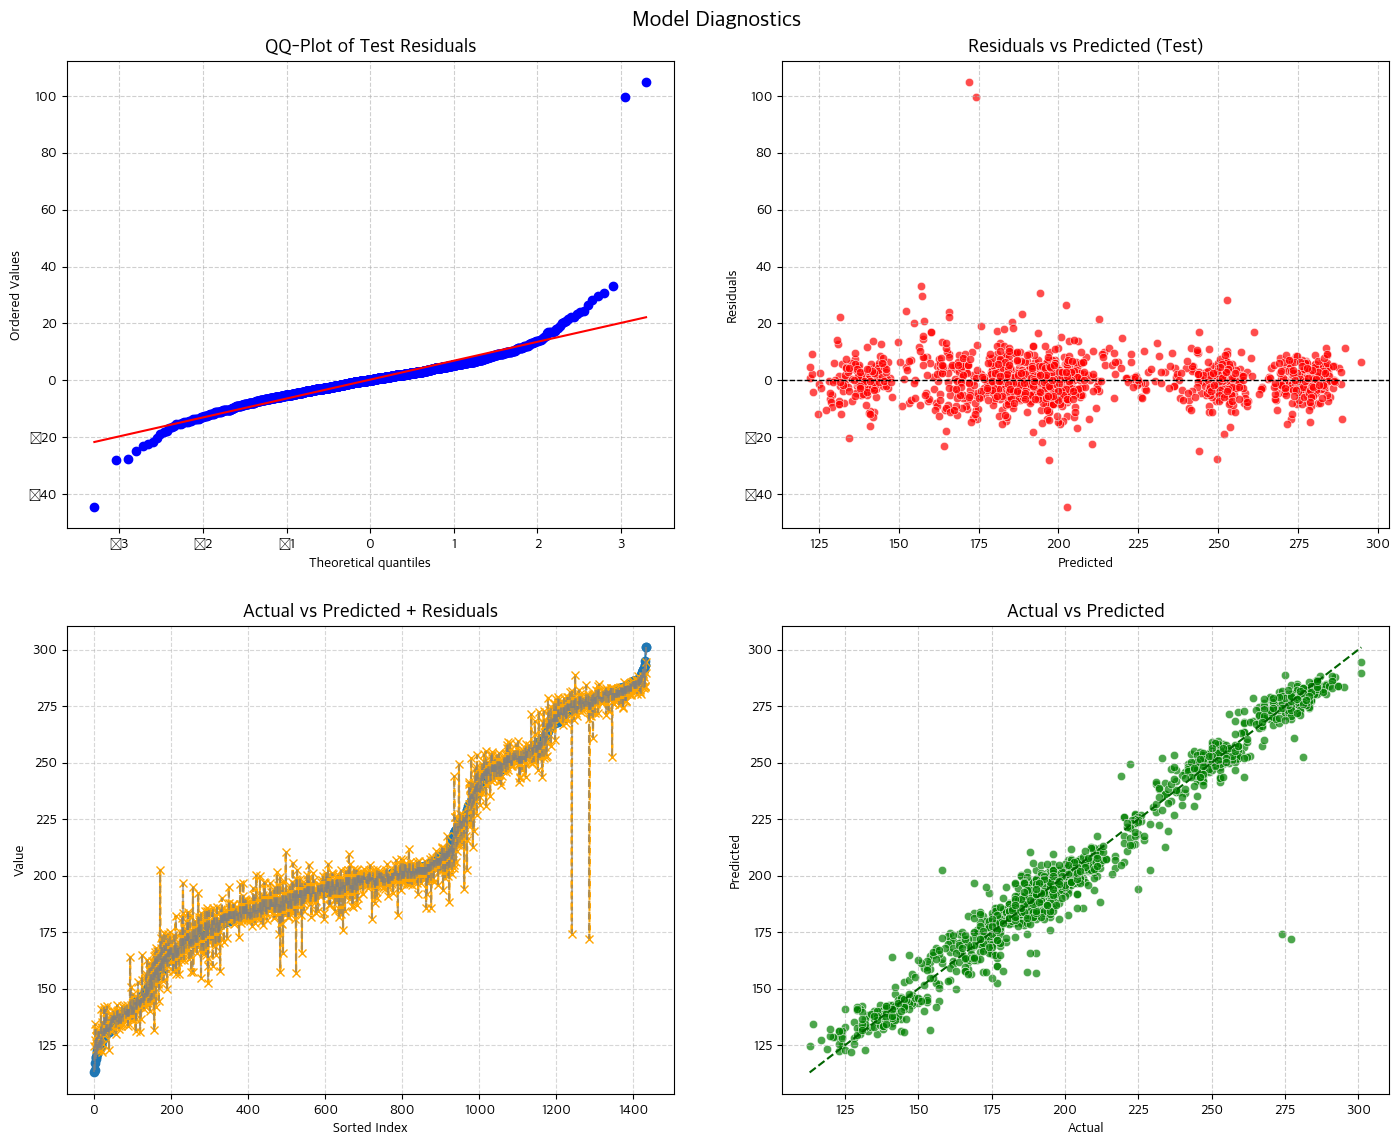

[I 2025-10-30 15:39:48,056] A new study created in memory with name: no-name-1cafd34a-53f3-412a-8546-3788ca9e76dc


Train Accuracy
Train RMSE : 1.047
Train R2   : 0.999
Train SMAPE : 0.41
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 7.448
Test R2   : 0.972
Test SMAPE : 2.43
학습할 Tree Features: 18 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Cluster']
학습 Tree 데이터 수: 8537


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-30 15:39:49,976] Trial 0 finished with value: 24.025334521760826 and parameters: {'n_estimators': 563, 'max_depth': 11, 'learning_rate': 0.045344978920091816, 'subsample': 0.9387687911566297, 'gamma': 0.4369351702680461, 'reg_lambda': 0.08128724730318239}. Best is trial 0 with value: 24.025334521760826.
[I 2025-10-30 15:39:54,766] Trial 1 finished with value: 25.097461108689803 and parameters: {'n_estimators': 999, 'max_depth': 12, 'learning_rate': 0.0025488192764342287, 'subsample': 0.7016860423287117, 'gamma': 0.12175308152784775, 'reg_lambda': 0.13800382164073718}. Best is trial 0 with value: 24.025334521760826.
[I 2025-10-30 15:39:57,867] Trial 2 finished with value: 23.462965482913585 and parameters: {'n_estimators': 2722, 'max_depth': 7, 'learning_rate': 0.053151164034225276, 'subsample': 0.8809240511517643, 'gamma': 0.41221801210431996, 'reg_lambda': 0.0039034445679893073}. Best is trial 2 with value: 23.462965482913585.
[I 2025-10-30 15:40:00,066] Trial 3 finished wi

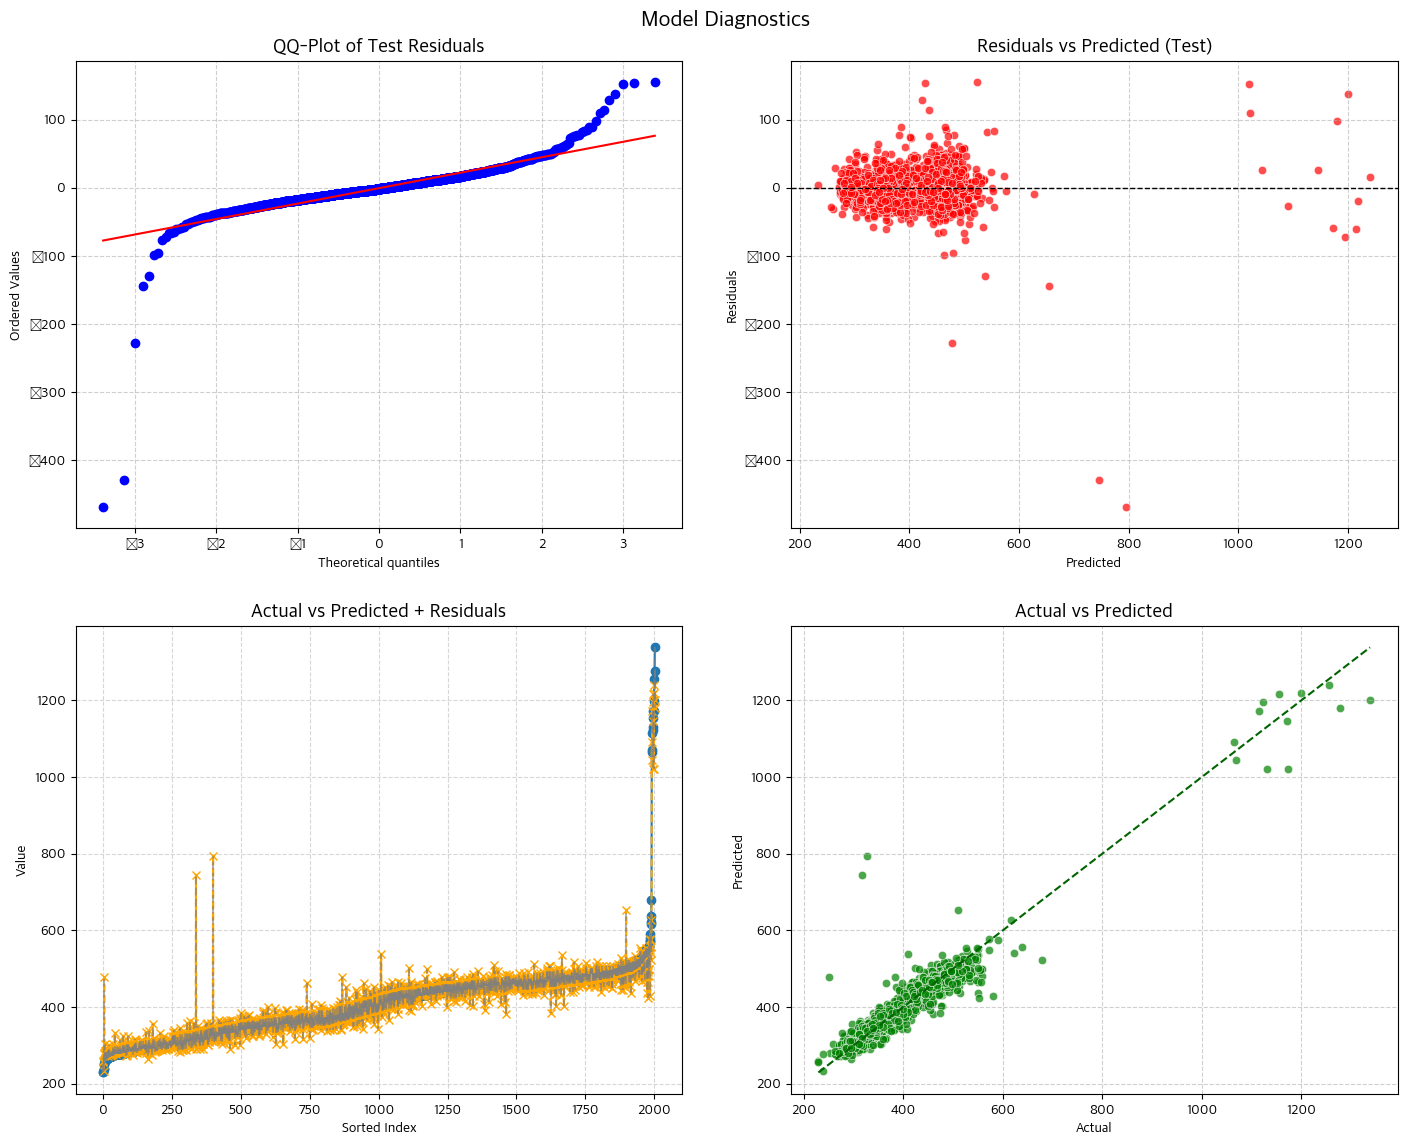

[I 2025-10-30 15:40:22,017] A new study created in memory with name: no-name-fa2c25a7-22c5-44cb-a9ff-f5eb25daf059


Train Accuracy
Train RMSE : 5.317
Train R2   : 0.996
Train SMAPE : 1.03
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 26.610
Test R2   : 0.921
Test SMAPE : 3.89
학습할 Tree Features: 18 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Cluster']
학습 Tree 데이터 수: 18863


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-30 15:40:23,817] Trial 0 finished with value: 1.4141241751928857 and parameters: {'n_estimators': 968, 'max_depth': 10, 'learning_rate': 0.05362517376726571, 'subsample': 0.9431482530319142, 'gamma': 0.04022400704105206, 'reg_lambda': 0.0011211223685777172}. Best is trial 0 with value: 1.4141241751928857.
[I 2025-10-30 15:40:25,720] Trial 1 finished with value: 1.414346493638899 and parameters: {'n_estimators': 884, 'max_depth': 9, 'learning_rate': 0.02605330038708895, 'subsample': 0.8230911560682196, 'gamma': 0.40900874642212387, 'reg_lambda': 0.12791595021172136}. Best is trial 0 with value: 1.4141241751928857.
[I 2025-10-30 15:40:28,131] Trial 2 finished with value: 1.4131749858229508 and parameters: {'n_estimators': 2552, 'max_depth': 9, 'learning_rate': 0.0396091296498067, 'subsample': 0.9762478206638707, 'gamma': 0.0901031954750447, 'reg_lambda': 0.004015229198961781}. Best is trial 2 with value: 1.4131749858229508.
[I 2025-10-30 15:40:29,499] Trial 3 finished with val

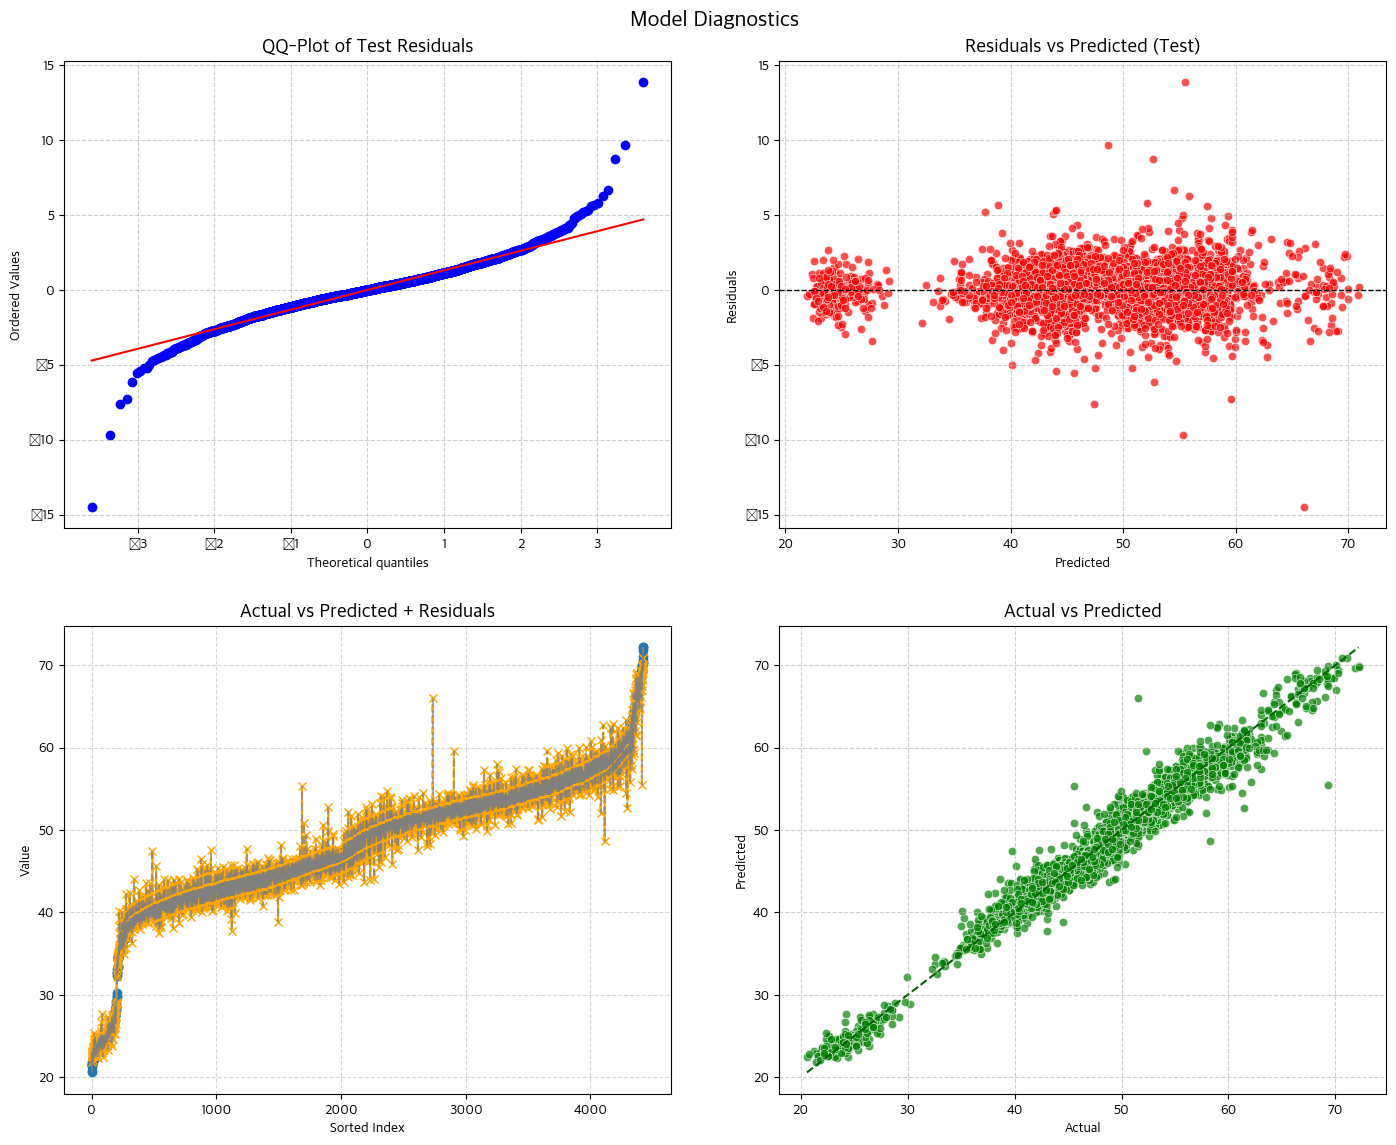

[I 2025-10-30 15:40:53,770] A new study created in memory with name: no-name-096dd5f4-fc4f-48a1-b45e-09dcc14973e9


Train Accuracy
Train RMSE : 0.363
Train R2   : 0.998
Train SMAPE : 0.59
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.344
Test R2   : 0.974
Test SMAPE : 2.05
학습할 Tree Features: 18 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature', 'Cluster']
학습 Tree 데이터 수: 13855


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-30 15:40:57,122] Trial 0 finished with value: 1.1375818303060243 and parameters: {'n_estimators': 2903, 'max_depth': 8, 'learning_rate': 0.017746798629286357, 'subsample': 0.9658888708521518, 'gamma': 0.1315418371283001, 'reg_lambda': 1.3374150071726847}. Best is trial 0 with value: 1.1375818303060243.
[I 2025-10-30 15:40:58,427] Trial 1 finished with value: 1.1402342561639056 and parameters: {'n_estimators': 610, 'max_depth': 9, 'learning_rate': 0.02915869440316432, 'subsample': 0.9800606442101147, 'gamma': 0.09745415860165368, 'reg_lambda': 2.634579152394644}. Best is trial 0 with value: 1.1375818303060243.
[I 2025-10-30 15:41:00,719] Trial 2 finished with value: 2.3279631966058565 and parameters: {'n_estimators': 613, 'max_depth': 12, 'learning_rate': 0.0011625250685515078, 'subsample': 0.7071635300512555, 'gamma': 0.42856868696268674, 'reg_lambda': 0.25987285126356086}. Best is trial 0 with value: 1.1375818303060243.
[I 2025-10-30 15:41:04,539] Trial 3 finished with valu

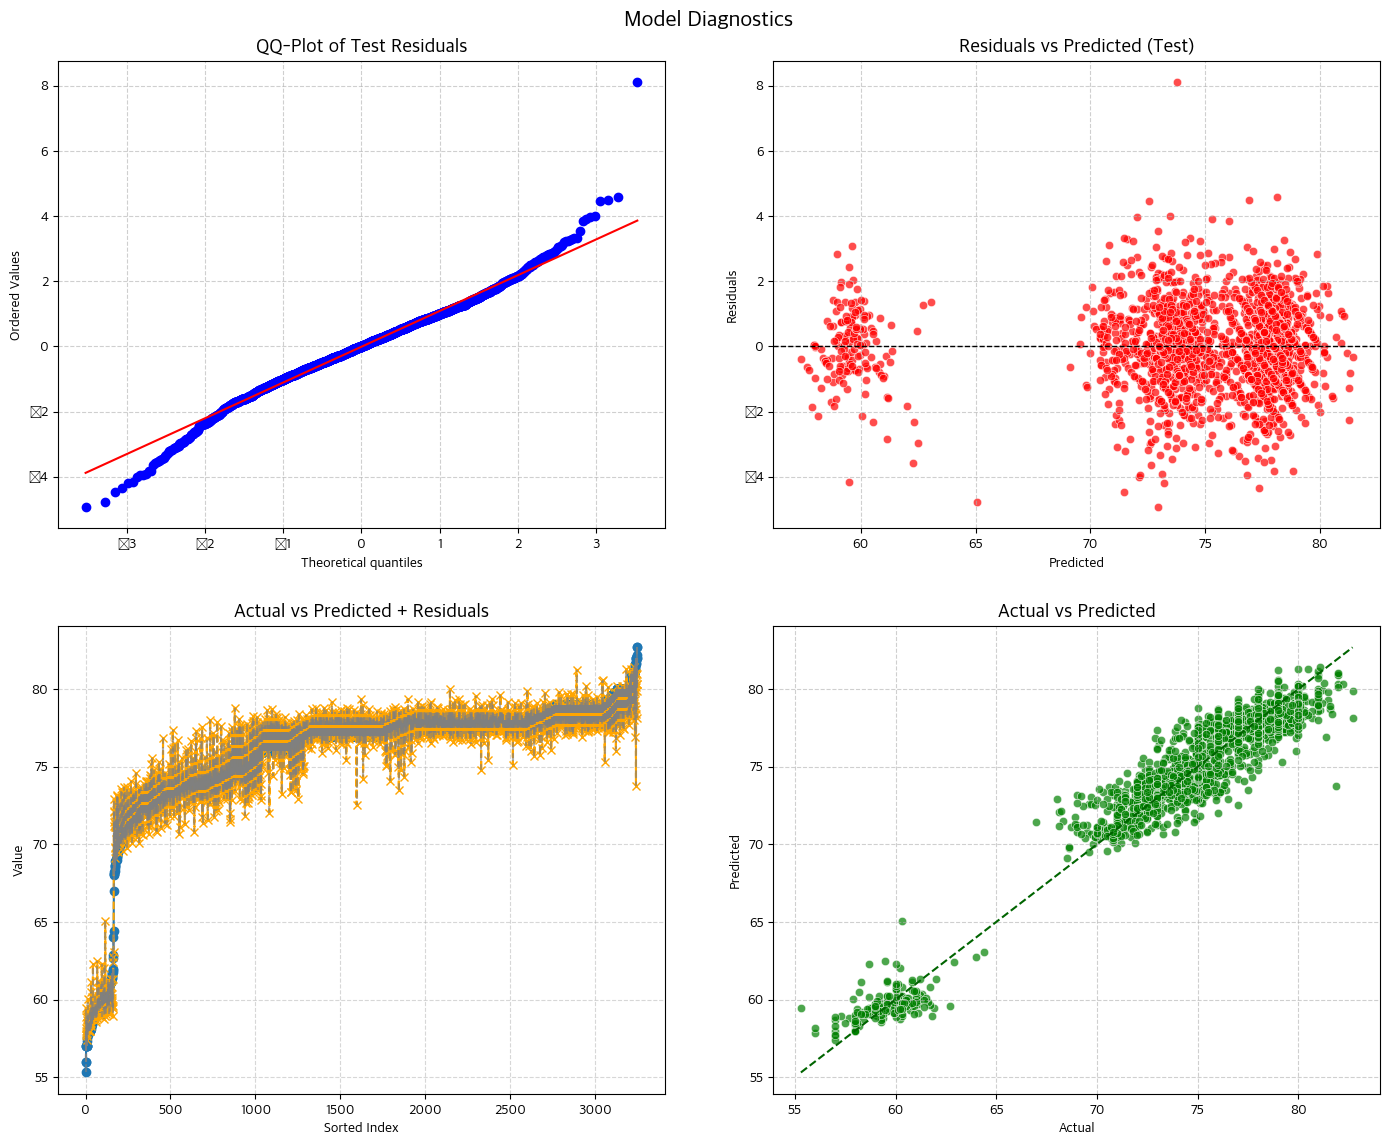

Train Accuracy
Train RMSE : 0.460
Train R2   : 0.989
Train SMAPE : 0.48
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.107
Test R2   : 0.938
Test SMAPE : 1.12


In [ ]:
### Modelling 
# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과') 

## ***Feature Importance***
---

In [ ]:
def shap_tree(df, scaler, scaler_features, model, target_col, cluster):  
    '''
    Shap Tree 적용하여 Feature Importance 추출 
        - Cluster와 해당 부분의 Optimal Target(std 5%)에 해당하는 데이터를 원본 데이터에서 필터링하여 -> Feature Importance 추출 
        - Cluster 6개 각각마다 지표 5개에 대한 Feature Importance 보유 
        - Cluster 1에 대하여 모든 Target 지표의 최적값을 맞추는데 필요한 중요 변수를 Voting 으로 집계 -> 지표마다 따로한다면? 30 Cases 
    
    Returns: Feature Importance 
    ''' 
    ################################# 필요 컬럼 및 데이터셋 추출 #################################
    # Copy 
    dataset = df.reset_index(drop=True).copy() 
    print(f'Cluster {cluster} | {target_col} => Feature Importance 추출 시작')    

    # Cluster 
    cluster_df = dataset['Cluster'] 

    # Target Cols 
    target_prefix = target_col.split('_')[0]
    target_prefix = re.match(r'^(.*?)_', target_col).group(1).replace(' ', '')
    target_criterion = [
                        col for col in dataset.columns
                        if col.replace(' ', '').startswith(target_prefix) and "기준" in col and col != target_col
                    ][0]

    # Dataset X, y 
    X_scaled = pd.DataFrame(scaler.transform(dataset[scaler_features]), columns=scaler_features)  
    y = dataset[[target_col, target_criterion]] 

    # Concat data 
    dataset = pd.concat([cluster_df, X_scaled, y], axis=1).dropna().reset_index(drop=True).copy() 

    ################################# Cond Data Filtering (Cluster) #################################
    # Cluster 조건 
    cluster_mask = (dataset['Cluster'] == cluster)

    # Print 
    print(f'Cluster 조건 적용된 데이터 수: {dataset[cluster_mask].shape}') 

    ################################# Cond Data Filtering (Optimal Target) #################################
    # Criterion Value 조정 
    dataset[target_criterion] = (
                                dataset[target_criterion]
                                .astype(str)
                                .str.extract(r'(\d+(?:\.\d+)?)', expand=False)
                                .astype(float)
                                )

    # Otpimal Target 조건 
    std = 0.03
    center = dataset[target_criterion] 
        # Upper Lower 
    lower = center * (1-std) 
    upper = center * (1+std) 
    
    # 범위 확인 
    optimal_target_mask = (dataset[target_col] >= lower) & (dataset[target_col] <= upper) 
    optimal_target_data = dataset[optimal_target_mask] 

    # Print 
    print(f'Optimal Target 조건 적용된 데이터 수: {optimal_target_data.shape}') 

    ################################# Combine Filters ################################# 
    # Combine Filters 
    combined_mask = cluster_mask & optimal_target_mask 
    filtered_dataset = dataset.loc[combined_mask].copy()

    # Print 
    print(f'모든 조건이 필터링된 데이터 수: {filtered_dataset.shape}')

    # Drop 
    cols_to_drop = ['Cluster', target_col, target_criterion]
    filtered_dataset = filtered_dataset.drop(columns=cols_to_drop, errors='ignore')

    ################################# Apply Tree Shap ################################# 
    # Tree Explainer 
    explainer = shap.TreeExplainer( 
            model, 
            data=filtered_dataset, # Cond 데이터 영역 안에서, 모델이 어떤 특성에 얼마나 반응하는가? => 데이터가 많을수록 좋다 std 확장 필요 
            # feature_perturbation="tree_path_dependent"
    )

    # Shap 값 계산 
    shap_values = explainer.shap_values(filtered_dataset)

    # Feature importance 계산 
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    feature_importance = pd.DataFrame({
                        'Target': target_col, 
                        "feature": scaler_features,
                        "mean_abs_shap": mean_abs_shap
                        }).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

    # 시각화를 위한 Shap Values 
    try:
        shap_values = explainer.shap_values(filtered_dataset)
    except AttributeError:
        # 최신 shap에서는 explainer(X) 형태를 권장
        shap_values = explainer(filtered_dataset).values

    return shap_values, filtered_dataset, feature_importance 


In [ ]:
### Shap Tree 적용 (Clutser 1)
targets = ['cycle time','Ct 90_결과','Scorch (T3)_결과','Vm (T3)_결과','경도_결과']

# CT90 
ct_shap_values, ct_filtered_dataset, ct_feature_importance = shap_tree(dataset, ct_scaler, ct_scaler_cols, ct_model, target_col=targets[1], cluster=cluster)

# Scorch 
sc_shap_values, sc_filtered_dataset, sc_feature_importance = shap_tree(dataset, sc_scaler, sc_scaler_cols, sc_model, target_col=targets[2], cluster=cluster)

# Vm 
vm_shap_values, vm_filtered_dataset, vm_feature_importance = shap_tree(dataset, vm_scaler, vm_scaler_cols, vm_model, target_col=targets[3], cluster=cluster)

# Hard 
hard_shap_values, hard_filtered_dataset, hard_feature_importance = shap_tree(dataset, hard_scaler, hard_scaler_cols, hard_model, target_col=targets[4], cluster=cluster)

# Voting 
feature_importances = [ct_feature_importance,sc_feature_importance,vm_feature_importance,hard_feature_importance]
cluster_1_feature_importance = voting_feature_importance(feature_importances) 

# Print 
print('='*100)
print(f'Cluster {cluster} Shap Tree Feature Importance 추출 완료')
print('='*100)

Cluster 1 | Ct 90_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (30598, 19)
Optimal Target 조건 적용된 데이터 수: (6129, 19)
모든 조건이 필터링된 데이터 수: (6129, 19)


ValueError: could not convert string to float: '[2.070221E2]'